<a href="https://colab.research.google.com/github/potguillaume/timberStrengthGradingDataset/blob/main/notebooks/analysis_dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import database from git

Filtering and computation

In [3]:
# @title
import pandas as pd
url = "https://raw.githubusercontent.com/potguillaume/timberStrengthGradingDataset/refs/heads/main/data/timberStrengthGradingDataset.csv"
df = pd.read_csv(url, sep=";")
df.info()
# Filtrer les donnÃ©es oÃ¹ testSuccess = 1
df_filtered = df[df['testSuccess'] == 1]

# Ajuster et Ã©craser globalStatMoE_MPa en fonction de mcPinTest_pc
df_filtered['globalStatMoE_MPa'] = (df_filtered['globalStatMoE_MPa'] * (1-(12-df_filtered['mcPinTest_pc'])*0.01))*1.3-2690

# CrÃ©er une nouvelle colonne pour le MoE combinÃ©
df_filtered['combinedMoE_MPa'] = df_filtered['globalStatMoE_MPa'].copy()
mask = (df_filtered['globalStatMoE_MPa'].isna()) | (df_filtered['globalStatMoE_MPa'] == 0)
df_filtered.loc[mask, 'combinedMoE_MPa'] = df_filtered.loc[mask, 'localStatMoE_MPa']

# CrÃ©er une colonne pour indiquer la source du MoE
df_filtered['MoE_source'] = 'global'
df_filtered.loc[mask, 'MoE_source'] = 'local'

df_filtered = df_filtered[~((df_filtered['strength_MPa'].isna()) | (df_filtered['strength_MPa'] == 0) |
                  (df_filtered['boardDensityTestManual_kgpm3'].isna()) | (df_filtered['boardDensityTestManual_kgpm3'] == 0) |
                  (df_filtered['combinedMoE_MPa'].isna()) )]

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4334 entries, 0 to 4333
Columns: 130 entries, project to distanceToPith_mm
dtypes: float64(111), int64(3), object(16)
memory usage: 4.3+ MB


/tmp/ipython-input-1253931279.py:4: DtypeWarning: Columns (10,14,49,51,53,55,83,96) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(url, sep=";")
/tmp/ipython-input-1253931279.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['globalStatMoE_MPa'] = (df_filtered['globalStatMoE_MPa'] * (1-(12-df_filtered['mcPinTest_pc'])*0.01))*1.3-2690
/tmp/ipython-input-1253931279.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['combinedMoE_MPa'] =

# Utils

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import linregress
def lin_regress(x, y):
    """
    Effectue une régression linéaire sur les données x et y.

    :param x: Valeurs de la variable indépendante.
    :param y: Valeurs de la variable dépendante.
    :return: intercept, slope, r_squared
    """
    slope, intercept, r_value, _, _ = linregress(x, y)
    r_squared = r_value ** 2
    return intercept, slope, r_squared

# Plot grade determining properties relationships by species

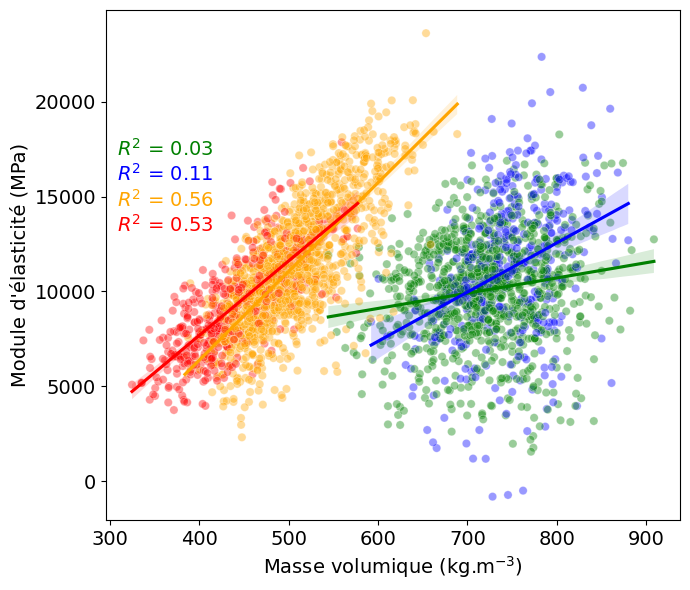

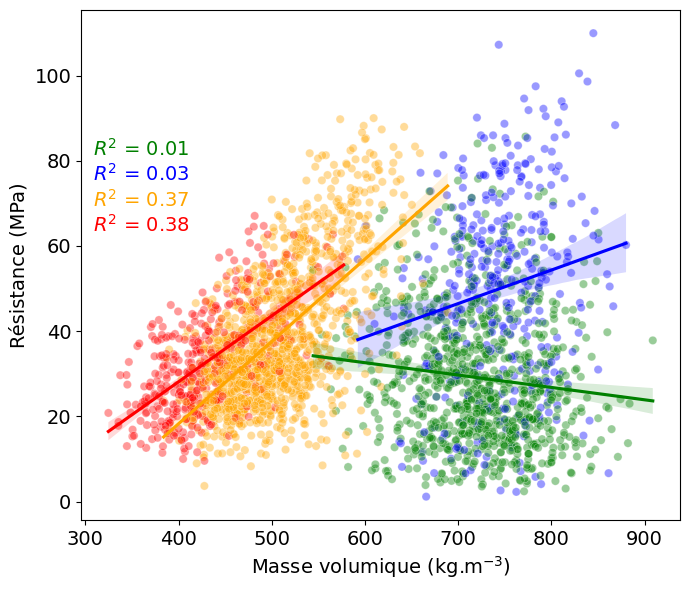

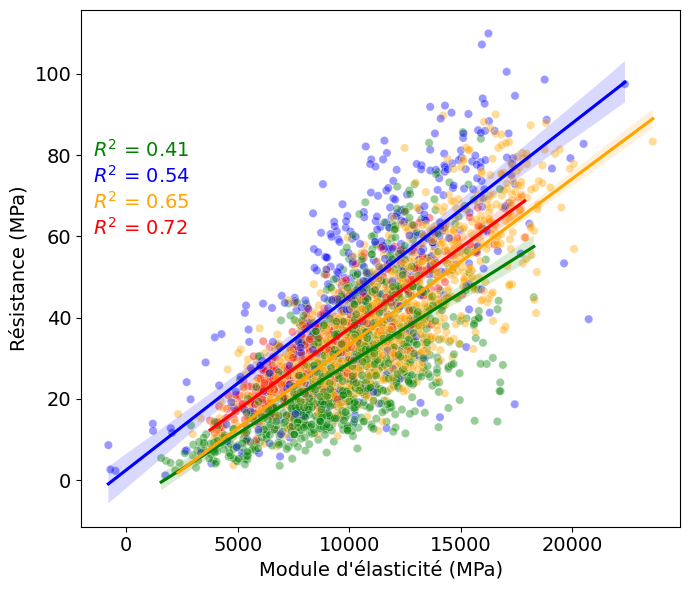

In [ ]:


variables = ['boardDensityTestManual_kgpm3','combinedMoE_MPa', 'strength_MPa']
variable_labels = {'strength_MPa': 'Résistance (MPa)', 'combinedMoE_MPa': 'Module d\'élasticité (MPa)', 'boardDensityTestManual_kgpm3': 'Masse volumique (kg.m$^{-3}$)'}

df_filtered['combined_hue'] = df_filtered.apply(lambda row: f"{row['species']}_{row['testType']}", axis=1)

unique_hues = df_filtered['combined_hue'].unique()

palettecoul=['green','blue','orange','red']
palette = {hue: palettecoul[i % len(palettecoul)] for i, hue in enumerate(unique_hues)}

for i in range(len(variables)):
    for j in range(i+1, len(variables)):
        plt.figure(figsize=(7, 6))

        df_cleaned = df_filtered[['combined_hue',variables[i], variables[j]]].copy()

        # Tracer les points de dispersion
        scatter = sns.scatterplot(data=df_cleaned, x=variables[i], y=variables[j],
                                  hue='combined_hue', alpha=0.4, palette=palette)

        # Obtenir les limites des axes
        ax = plt.gca()
        x_lim = ax.get_xlim()
        y_lim = ax.get_ylim()

        # Ajouter les régressions linéaires pour chaque espèce
        for idx, combined_hue in enumerate(unique_hues):
            species_data = df_cleaned[df_cleaned['combined_hue'] == combined_hue]
            intercept, slope, r_squared = lin_regress(species_data[variables[i]], species_data[variables[j]])

            # Tracer la ligne de régression
            sns.regplot(data=species_data, x=variables[i], y=variables[j],
                        scatter=False, color=palette[combined_hue])
            plt.legend().remove()

            # Créer un rectangle blanc derrière le texte
            text_box = dict(facecolor='white', edgecolor='none', alpha=0.7)

            # Annoter l'équation de la régression et le R² avec le rectangle blanc
            # plt.text(0.02, 0.75 - 0.05 * idx,
            #           f'y = {slope:.2e}x + {intercept:.2e}, $R^2$ = {r_squared:.2f}',
            #           transform=plt.gca().transAxes, fontsize=10, verticalalignment='top',
            #           color=palette[combined_hue], bbox=text_box)
            plt.text(0.02, 0.75 - 0.05 * idx,
                          f'$R^2$ = {r_squared:.2f}',
                          transform=plt.gca().transAxes, fontsize=14, verticalalignment='top',
                          color=palette[combined_hue], bbox=text_box)

        plt.tick_params(axis='both', which='major', labelsize=14)
        plt.xlabel(variable_labels[variables[i]], fontsize=14)
        plt.ylabel(variable_labels[variables[j]], fontsize=14)
        #plt.legend()
        plt.tight_layout()
        plt.gcf().patch.set_alpha(0)
        plt.show()
        # Sauvegarder avec un fond transparent
        plt.savefig(f'figure_{variables[i]}_vs_{variables[j]}.svg', format='svg', transparent=True)
        plt.savefig(f'figure_{variables[i]}_vs_{variables[j]}.png', format='png', transparent=True, dpi=300)

        # Fermer le graphique global
        plt.close()

